# Introduction: Gradient Boosting Machine

Primary Sources: [Tree Boosting with XGBoost](https://brage.bibsys.no/xmlui/bitstream/handle/11250/2433761/16128_FULLTEXT.pdf?sequence=1&isAllowed=y), [Greedy Function Approximation: A Gradient Boosting Machine](http://statweb.stanford.edu/~jhf/ftp/trebst.pdf), and [Hands-On Machine Learning with Scikit-Learn and TensorFlow](http://shop.oreilly.com/product/0636920052289.do)

The gradient boosting machine is an ensemble machine learning model that has risen to prominence in recent years due to exceptional performance on structured machine learning tasks. The gradient boosting machine not surprisingly is a boosting model, one of the two types of ensembles:

* bagging (bootstrap aggregating): train individual learners independently and make a prediction by averaging individual predictions
* boosting: train individual learners in sequence, with each individual learning from the mistakes of the previous. Predictions are made by weighting the predictions inversely proportional to the error of the individual. 

The modeling notebook showed examples of both ensembles: random forest and extra trees are bagging methods while AdaBoost (adaptive boosting) is a boosting ensemble. Whereas in adaptive boosting, the observations are re-weighted each iteration according to the magnitude of their residuals (with larger residuals receiving greater weight), in gradient boosting, the learners are trained directly on the residuals of the entire ensemble. Both methods are teaching each successive learner to focus on the errors of the previous learners, but using different methods. Furthermore, while adaptive boosting weights the individuals according to their performance on the training set, the contribution of each learner in gradient boosting is learned through an iterative gradient descent optimization method. The ultimate goal of machine learning is to approximate a function that maps the features to the targets, and gradient boosting can therefore be thought of as gradient descent in function space. 

Gradient Boosting is a general method that can be applied to any differentiable objective function and use any individual models (called weak learners). The most common weak learner is the decision tree leading to particular type of gradient boosting known as Gradient Boosted Regression Trees (GBRT). There are several open-source libraries for implementing Gradient Boosting in Python including [Scikit-Learn](http://scikit-learn.org/stable/index.html), [LightGBM](http://lightgbm.readthedocs.io/en/latest/), [XGBoost](https://xgboost.readthedocs.io/en/latest/), and [CatBoost](https://catboost.yandex/). Although Scikit-Learn is a go-to library for many machine learning algorithms, its version of the Gradient Boosting model is [less performant](https://datascience.stackexchange.com/questions/10943/why-is-xgboost-so-much-faster-than-sklearn-gradientboostingclassifier) with fewer customizations than the other options. In this notebook, we will implement a gradient boosting machine using the [LightGBM library](https://github.com/Microsoft/LightGBM) from Microsoft. This library includes a number of variations on the gradient boosting framework including [Dropout meets Multiple Addivive Regression Trees (DART)](https://arxiv.org/abs/1505.01866) and [Gradient-based One Sided Sampling (GOSS)](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf). We will stick to using the Gradient Boosting Regression Trees method. 

This notebook will cover some of the best practices for building a gradient boosting machine collected from multiple machine learning competitions and published research. We will put these practices to use by building a gradient boosting model step by step for the supervised regression building energy prediction problem. The end outcome is a function that will allow us to evaluate the gradient boosting machine alongside the other models developed in the [Modeling notebook](https://bitbucket.org/willkoehrsen/prediction-documentation/src/670f76b3c327aed7916cd2d73f3f84dec8d71c98/notebooks/Modeling.ipynb?at=master&fileviewer=file-view-default). These models will be tested on hundreds of building datasets to determine the most promising model for further development. 

## Imports

We will use a standard stack of data science tools along with the [LightGBM library](https://lightgbm.readthedocs.io/en/latest/): `pandas`, `numpy`, `matplotlib`, `seaborn`, `sklearn`, `lightgbm`. We also import `gc` for memory management (garbage collection), `warnings` to filer out warnings from `pandas`, and the `preprocess_data` function we wrote in the [Preprocessing notebook](https://bitbucket.org/willkoehrsen/prediction-documentation/src/670f76b3c327aed7916cd2d73f3f84dec8d71c98/notebooks/Preprocessing.ipynb?at=master&fileviewer=file-view-default). Please refer to the `requirements.txt` file for the correct version of the packages to install. 

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

# Modeling library
import lightgbm as lgb

# Using KFold cross validation
from sklearn.model_selection import KFold

# Encoding categorical features
from sklearn.preprocessing import LabelEncoder

# Scikit-Learn Machine Learning models
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor

# Memory management
import gc

# Prepocess data for machine learning
from utilities import preprocess_data, implement_model

# Timing utility
from timeit import default_timer as timer

#### Read in Example Data and Preprocess

In this notebook we will work with two example datasets to illustrate the process of building and using the model. The preprocessing is done using the function developed in the Preprocessing notebook. As with the other six models demonstrated in the Modeling notebook, the gradient boosting machine will be eventually be run on hundreds of buildings in order to get an accurate assessment of its performance. 

In [2]:
# Read in example data
df = pd.read_csv('../data/f-APS_weather.csv')

# Preprocess for machine learning
train, targets, test, test_targets = preprocess_data(df)

train.head()

,timestamp,biz_day,week_day_end,ghi,dif,gti,temp,rh,pwat,ws,...,yday_cos,month_sin,month_cos,wday_sin,wday_cos,num_time_sin,num_time_cos,sun_rise_set_neither,sun_rise_set_rise,sun_rise_set_set
0,0.000000,1.0,0.0,0.0,0.0,0.0,0.394397,0.245303,0.069231,0.295082,...,0.629749,0.066987,0.75,1.0,0.25,0.500000,1.000000,1.0,0.0,0.0
1,0.000011,1.0,0.0,0.0,0.0,0.0,0.390086,0.250522,0.067949,0.295082,...,0.629749,0.066987,0.75,1.0,0.25,0.533050,0.998907,1.0,0.0,0.0
2,0.000022,1.0,0.0,0.0,0.0,0.0,0.387931,0.256785,0.067949,0.295082,...,0.629749,0.066987,0.75,1.0,0.25,0.565955,0.995631,1.0,0.0,0.0
3,0.000034,1.0,0.0,0.0,0.0,0.0,0.383621,0.262004,0.067949,0.303279,...,0.629749,0.066987,0.75,1.0,0.25,0.598572,0.990187,1.0,0.0,0.0
4,0.000045,1.0,0.0,0.0,0.0,0.0,0.379310,0.268267,0.067949,0.303279,...,0.629749,0.066987,0.75,1.0,0.25,0.630758,0.982600,1.0,0.0,0.0


The data is now ready for machine learning: all of the features are numeric, there are no missing values, and the features have been scaled between 0 and 1. The [gradient boosting machine can handle missing values](https://github.com/Microsoft/LightGBM/issues/122) and does not need scaled features, but because we are comparing performance to other models, we will use the same standard set of features. 

### Define Evaluation Metric

The evaluation metric we selected is the Mean Absolute Percentage Error (MAPE). The definition of MAPE is the average of the absolute residuals divided by the true values: 

$$\mbox{MAPE} = 100\% * \frac{1}{n}\sum_{i=1}^n  \left|\frac{y_i-\hat{y}_i}{y_i}\right|$$

In order to use this evaluation metric in LightGBM, we need to write a [custom evaluation metric function](https://github.com/Microsoft/LightGBM/issues/284) that takes in the true targets and the predictions. The output of this function must be three arguments: 

* A `string` representing the name of the metric
* A `float` for the value of the metric
* A `boolean` stating if a higher value is better (which is False because a lower MAPE is better)

We can pass in this function to the model during training to be used as the evaluation metric for early stopping. 

In [3]:
# Evaluation metric
def mape(true, predictions):
    """Calculates the mean absolute percentage error given the true
    values and predictions. Return is formatted for a LightGBM custom evaluation metric."""
    
    return 'mape', 100 * np.mean(abs(true - predictions) / true), False

# LightGBM Regression Model

Again these sources are extremely helpful ([Tree Boosting with XGBoost](https://brage.bibsys.no/xmlui/bitstream/handle/11250/2433761/16128_FULLTEXT.pdf?sequence=1&isAllowed=y), [Greedy Function Approximation: A Gradient Boosting Machine](http://statweb.stanford.edu/~jhf/ftp/trebst.pdf), and [Hands-On Machine Learning with Scikit-Learn and TensorFlow](http://shop.oreilly.com/product/0636920052289.do))

A gradient boosting machine has many hyperparameters to tune. In this notebook, and for evaluation of all buildings, we will use a standard set of hyperparameters (for all but one of the settings) selected by analyzing best practices recommended by research papers and the documentation for the library. Moreover, we will use early stopping to determine one of the most important hyperparameters, the number of decision trees trained (this is also known as the number of boosting rounds or the number of iterations). 

## Gradient Boosting Machine Hyperparameters 

There are two sets of hyperparameters in a gradient boosting machine: those that apply to the overall ensemble, and those that apply to the individual learners in the ensemble. These hyperparameters are used to control the bias/variance tradeoff: higher variance leads to overfitting while high bias leads to underfitting. Both situations decrease generalization performance on the test set.


### Ensemble Hyperparameters

The two main hyperparameters that pertain to the entire ensemble are:

* `n_estimators`: number of base learners used, equivalently the number of boosting rounds. More estimators decreases the bias but increases the variance which can lead to overfitting. This hyperparameter can be set using early stopping. 
* `learning_rate`: the contribution of each new learner to the ensemble. A larger learning rate will increase the rate of convergence but may lead the algorithm to jump around the optimum (lowest point) of the objective function. A lower learning rate will lead to longer training times but can improve generalization on the test set. 

There are a few other hyperparameters that deal with the entire model. However, we will only set one other different than the default:

* `subsample`: the fraction of observations to use for training each base learner. By default the GBM uses all of the training examples, but by randomly samping a subset of the observations, the variance of the model can be reduced. 

We will use the following set of ensemble hyperparameters (all others are kept at the defaults):

* `n_estimators=10000`: this number of base learners will likely not be reached because of early stopping
* `learning_rate=0.01`: This is a decrease of three-quarters from the default of 1.0
* `subsample=0.9`: sample 90% of the training examples for training

The number of estimators will not actually be 10,000 for many of the training runs because we will use early stopping to determine the ideal value. 


### Early Stopping

Early stopping continues adding learners to the ensemble until the error on a validation set has not decreased for a set number of iterations. For example, here we will use early stopping by adding more learners until the MAPE on the validation set has not decreased for 100 iterations. The model records the number of estimators that resulted in the lowest error and then this number of estimators is used to make predictions on the test set.

The concept of early stopping is illustrated in the following image:

![image](../images/early_stopping.png)


Early stopping is an effective technique for choosing the ideal number of base learners and is commonly used for training gradient boosting machines. Early stopping greatly simplifies the process of finding the optimal number of iterations. Using early stopping does require a validation set though, which reduces the amount of training data. However, we can get around this limitation by selecting the number of iterations using the technique of cross validation.


### Cross Validation

Cross validation (cv) is another best practice in machine learning. Often, the ideal model hyperparameters require a validation set to determine. The validation set must be drawn from the __training data__ and not the testing data. Splitting the training data into two sets though reduces the amount of training data, which can have a detrimental effect on performance. Moreover, optimizing the hyperparameters for a single validation set can just lead to overfitting on the _validation data_. Therefore, a technique known as cross-validation is used to avoid the need for a separate validation set and to better predict the generalization error of the model. The most common implementation of cross validation is K-Fold Cross Validation. 

#### K-Fold Cross Validation

In K-Fold cross validation, the training data is split into K folds and then training proceeds in an iterative manner. On each iteration, the model is trained on K-1 of the sets and tested on the Kth set. This continues for K iterations until eventually all of the training data has been used as a validation set. The final estimate of the performance of the model is the average performance across the K validation scores. This method eliminates the need to split the valuable training data and usually provides a better measure of the generalization performance than using one validation set. The final model is then trained on the entire training data before making predictions. 

Below is an image of using 5-fold cv:

![image](../images/5-fold.png)

[Source](https://tex.stackexchange.com/questions/429451/k-fold-cross-validation-figure-using-tikz-or-table)

We will use K-Fold cross validation in order to determine the ideal number of base learners. We will split the data into 5 folds, and each fold, train until the MAPE on the validation fold does not decrease for 100 iterations. Each iteration, the best number of learners is recorded, and the final number of learners used is the average of the best number from the 5 validation runs. After completing 5-fold cv, the model is trained on the entire set of training data using the optimal number of iterations. Ideally this procedure will find a near-optimal number of iterations that will result in high generalization performance on the test set. 

While K-Fold cv can be used to select the number of estimators, the other hyperparameters will have to be set at a constant value for all of the evaluation. The other main hyperparameter governing the entire model is the learning rate which will be set at 0.01. Generally, a smaller learning rate is used to complement a larger number of estimators. The maximum number of estimators is 10000, and although this number likely will not be reached because of early stopping, the learning rate is set at 0.01 to prevent the model from "jumping" around the optimum value of the objective function. 


## Regularization and Individual Learner Hyperparameters

The Gradient Boosting Machine can be regularized both on the ensemble level and the base learner level. To regularize the model on the ensemble level, the number of estimators can be reduced. On the individual learner level, there are a number of hyperparameters that can be adjusted. We can limit the complexity of each tree by limiting the maximum depth, establishing a minimum number of observations required in each leaf node, or limiting the maximum number of leaf nodes among other methods. We can also penalize the complexity of the trees by adding terms to the objective function proportional to the L1 and L2 norm of the weights of the tree. We will impose regularization on the individual learners by setting the following hyperparameters:

* `reg_alpha=0.1`: Penalty on L1 norm of the tree weights
* `reg_lambda=0.1`: Penality on L2 norm of the tree weights

The final hyperparameters we set in the call to the model are:

* `n_jobs=-1`: Use all available cores on the machine for training

__All of the rest of the hyperparamters are set at the defaults.__ These defaults should be reviewed and can be [ound in the documentation](https://lightgbm.readthedocs.io/en/latest/Python-API.html#scikit-learn-api)

### Model Set Up

Here we build the model with the specified hyperparameters. In this run I also set the `random_state` to ensure consistent results across runs. 

In [4]:
# Create the model with specified hyperparameters
model = lgb.LGBMRegressor(n_estimators=10000,
                          learning_rate = 0.01, 
                          reg_alpha = 0.1, reg_lambda = 0.1, 
                          subsample = 0.9, n_jobs = -1,
                          random_state=100)

model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.01, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
       n_jobs=-1, num_leaves=31, objective=None, random_state=100,
       reg_alpha=0.1, reg_lambda=0.1, silent=True, subsample=0.9,
       subsample_for_bin=200000, subsample_freq=1)

### Cross Validation Applied

We will use five-fold cross validation for early stopping. To actually split the data, we have to convert the features into numpy arrays. 

In the code below, we make the [`KFold` object](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html), and then show a single iteration of splitting the data. 

In [5]:
# Kfold cross validation
kfold = KFold(n_splits=5)

# Split the training data
for i, (train_indices, valid_indices) in enumerate(kfold.split(np.array(train))):
    
    if i > 0: 
        break
    
    # Training data for fold
    train_features, train_targets = np.array(train)[train_indices], targets[train_indices]
    
    # Validation data for fold
    valid_features, valid_targets = np.array(train)[valid_indices], targets[valid_indices]

    print('Training Data Shape for Fold: ', train_features.shape)
    print('Validation Data Shape for Fold: ', valid_features.shape)

Training Data Shape for Fold:  (71416, 21)
Validation Data Shape for Fold:  (17855, 21)


Each fold will be used for validation exactly once. The validation data is used to determine the number of estimators (rounds of boosting) used by the model on each fold. The number of estimators used in the final full round of training will be the average of the best number of estimators returned from each round of cross validation. 

# Training the Model

To illustrate what will happen on each fold, we can train the model on a single fold using the validation data for early stopping. We pass the model:

* `X = train_features`: training features
* `y = train_targets`: training targets
* `early_stopping_rounds = 100`: Stop training after the validation metric has not decreased for 100 rounds
* `eval_metric = mape`: evaluation metric used for early stopping. The model will stop training when this metric does not decrease for the specified number of early stopping rounds.
* `eval_set = [(valid_features, valid_labels),(train_features, train_labels)]`: evaluation data to be used for early stopping. The model will only use the validation data for early stopping but will still evaluate the metrics for the training data. We can use the difference between the metrics to assess the amount of overfitting.
* `eval_names = ['valid', 'train']`: names of the evaluation sets of data
* `verbose = 500`: print out statistics about training and validation scores every 500 rounds (every 500 estimators trained)

Let's see what this looks like in action. 

In [6]:
# Train the model
model.fit(X = train_features, y = train_targets, 
          early_stopping_rounds = 100,
          eval_metric = mape,
          eval_set = [(valid_features, valid_targets), 
                      (train_features, train_targets)],
          eval_names = ['valid', 'train'], verbose = 500);

Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.634723	valid's mape: 9.06663	train's l2: 0.682509	train's mape: 9.29991
[1000]	valid's l2: 0.594519	valid's mape: 8.80087	train's l2: 0.544038	train's mape: 8.05561
Early stopping, best iteration is:
[1025]	valid's l2: 0.592757	valid's mape: 8.79411	train's l2: 0.539732	train's mape: 8.02122


Early stopping kicked in at round 1025 (it might be different depending on the run) because the error on the validation score had not improved for 100 rounds. We can use the best number of iterations found on this validation fold to make predictions on the test set. First, we rebuild the model and fit on the entire training set using the optimum number of iterations, and then we make predictions. 

In [7]:
print('Best number of iterations: ', model.best_iteration_)


# Create the model with specified hyperparameters
model = lgb.LGBMRegressor(n_estimators=model.best_iteration_,
                          learning_rate = 0.01, 
                          reg_alpha = 0.1, reg_lambda = 0.1, 
                          subsample = 0.9, n_jobs = -1,
                          random_state=100)


model.fit(train, targets)

# Make predictions on the test set
predictions = model.predict(np.array(test))

Best number of iterations:  1025


Then we can score the model using the evaluation metric.

In [8]:
_, mape_score, _ = mape(test_targets, predictions)
print('MAPE on the test set: %0.5f' % mape_score)

MAPE on the test set: 16.23532


If we used a differerent validation fold then the ideal number of iterations would likely have been different. This is the reason we used 5-fold cv: we want to get a better idea of the best number of iterations than a single validation would show. 

## Cross Validation

To actually use cross validation, we need to repeat the same process 4 more times, using the other 4 folds as validation once each. To use this process, we can write a simple loop. 

In [9]:
iterations = 0

# Split the training data
for i, (train_indices, valid_indices) in enumerate(kfold.split(np.array(train))):

    # Training data for fold
    train_features, train_targets = np.array(train)[train_indices], targets[train_indices]
    
    # Validation data for fold
    valid_features, valid_targets = np.array(train)[valid_indices], targets[valid_indices]

    # Train the model
    model.fit(X = train_features, y = train_targets, 
              early_stopping_rounds = 100,
              eval_metric = mape,
              eval_set = [(valid_features, valid_targets), 
                          (train_features, train_targets)],
              eval_names = ['valid', 'train'], verbose = 500)
    
    # Add the number of iterations to the total for averaging
    iterations += model.best_iteration_
    
    # Evaluate the mape
    _, valid_mape, _ = mape(valid_targets, model.predict(valid_features, 
                                                         num_iteration=model.best_iteration_))
    
    print('\nFold %d \t Validation MAPE: %0.5f\n' % (i, valid_mape))
    
iterations = int(iterations / kfold.n_splits)
print('\n Best Number of Iterations: ', iterations)

Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.634723	valid's mape: 9.06663	train's l2: 0.682509	train's mape: 9.29991
[1000]	valid's l2: 0.594519	valid's mape: 8.80087	train's l2: 0.544038	train's mape: 8.05561
Did not meet early stopping. Best iteration is:
[1025]	valid's l2: 0.592757	valid's mape: 8.79411	train's l2: 0.539732	train's mape: 8.02122

Fold 0 	 Validation MAPE: 8.79411

Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 2.01266	valid's mape: 13.2204	train's l2: 0.529106	train's mape: 8.40169
Early stopping, best iteration is:
[629]	valid's l2: 1.99781	valid's mape: 13.1469	train's l2: 0.483788	train's mape: 7.92668

Fold 1 	 Validation MAPE: 13.14687

Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.83468	valid's mape: 11.3004	train's l2: 0.651426	train's mape: 8.58868
[1000]	valid's l2: 0.759987	valid's mape: 10.4665	train's l2: 0.518724	train's mape: 7.46587
Did not mee

Looking at the results, we can see the model overfits because the validation error is significantly higher than the training error. This can be addressed by regularizing the overall model or the individual learners in the ensemble. In this case, since we are already using Early Stopping, we probably would want to consider regularization on an individual learner basis. For now, we will not add any more regularization. If the model performs well on all the buildings, then we can come back and address the overfitting issue. This would involve using random search with cross validation to find the regularization hyperparameters that perform the best. 

Once the cross validation has finished, we need to retrain the model on the entire training set. This time, we will use the average number of optimum iterations that were returned from the cross validation.

In [10]:
# Recreate the model with the optimal number of estimators
model = lgb.LGBMRegressor(n_estimators=iterations,
                          learning_rate = 0.01, 
                          reg_alpha = 0.1, reg_lambda = 0.1, 
                          subsample = 0.9, n_jobs = -1)

# Refit on the entire training data
model.fit(train, targets)


_, mape_score, _ = mape(test_targets, model.predict(np.array(test), num_iteration=iterations))
print('MAPE on the test set: %0.5f' % mape_score)

MAPE on the test set: 16.44667


For comparison, the best model on this dataset on the six Scikit-Learn models was the random forest with a test MAPE of 15.70. We will have to use more data in order to find out which model really is best! 

## Feature Importances

Machine learning is often criticized as a black box: we put in some data and recieve answers - often extremely accurate answers - with no explanations. One method we can use to peer into the black box of gradient boosting machines are feature importances. For a gradient boosting model based on individual decision trees, the [feature importances represent the decrease in impurity from including the feature in the model](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined). The absolute value of the feature importances can be [difficult to interpret](https://papers.nips.cc/paper/4928-understanding-variable-importances-in-forests-of-randomized-trees.pdf), but the relative magnitude of the importances can be used to determine which features the model considers "most important". 
We can use these importances for feature selection (which is more important when the number of features is large) or to try and understand how the model makes predictions.

Feature importances can be extracted from a trained gradient boosting model as follows.

In [11]:
feature_names = list(train.columns)
importances = model.feature_importances_

# Dataframe of feature importances
feature_importances = pd.DataFrame({'feature': feature_names, 
                                    'importance': importances})

# Sort the features by their importance
feature_importances.sort_values('importance', ascending = False)

,feature,importance
0,timestamp,4577
16,num_time_sin,3869
17,num_time_cos,3013
6,temp,2503
10,yday_sin,1874
11,yday_cos,1782
4,dif,1645
1,biz_day,1197
3,ghi,1018
8,pwat,980


The most important feature is the `timestamp` which we converted to a numeric to represent the number of seconds since the beginning of the data. The second most important feature is `num_time_sin`, one of the cyclical representations of the time of day, followed by the `temp` (the temperature at the building's location). These importances makes sense based on our domain knowledge because energy use is highly dependent on the time of day and the temperature. While it may be a mistake to read too much into the feature importances, it is reassuring that they agree with our domain knowledge. 

We can make a quick plot to show the normalized feature importances where each importance is divided by the sum of the importances. 

In [12]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance from a model (usually a tree-based model). 
    
    Parameters
    --------
        df : dataframe
            feature importances. Must have the features in a column
            called `features` and the importances in a column called `importance
        
    Return
    --------
        shows a plot of the 15 most importance features
        
        df : dataframe
            feature importances sorted by importance (highest to lowest) 
            with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

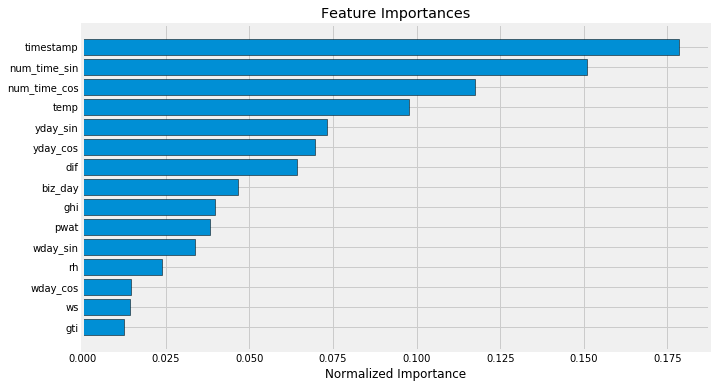

In [13]:
_ = plot_feature_importances(feature_importances)

# Gradient Boosting Machine Modeling Function

The next step is to refactor all of the indvidual code we walked through into a single function. This function will create the model, perform cross validation to find the optimal number of iterations, train the model on the whole training dataset using the optimal number of iterations, make predictions on the test data, and evaluate the MAPE on the test set. In order to integrate with the other models implemented in the modeling notebook, this function needs to return a numpy array:

`['model', train_time, test_time, test_mape]`

It also must take in the same arguments: a set of training features, training targets, a set of testing features, testing targets. We will suppress the messages returned during training for this function.

In [14]:
def gbm_model(train, targets, test, test_targets, n_folds = 5):
    """Train and test a light gradient boosting model using
    cross validation to select the optimal number of training iterations. 
    
    Parameters
    --------
        train : dataframe, shape = [n_training_samples, n_features]
            Set of training features for training a model
    
        targets : array, shape = [n_training_samples]
            Array of training targets for training a model

        test : dataframe, shape = [n_testing_samples, n_features]
            Set of testing features for making predictions with a model

        test_targets : array, shape = [n_testing_samples]
            Array of testing targets for evaluating the model predictions
        
    Return
    --------
        results : array, shape = [4]
            Numpy array of results. 
            First entry is the model, second is the training time,
            third is the testing time, and fourth is the MAPE. All entries
            are in strings and so will need to be converted to numbers.
        
    """
    
    # KFold cross validation object
    kfold = KFold(n_splits = n_folds)
    
    # Convert to numpy arrays
    train = np.array(train)
    test = np.array(test)
    
    best_iterations = 0
    
    # Create the model with specified hyperparaters
    model = lgb.LGBMRegressor(n_estimators=10000,
                              learning_rate = 0.01, 
                              reg_alpha = 0.1, reg_lambda = 0.1, 
                              subsample = 0.9, n_jobs = -1)
    
    # Cross validation to find optimal number of iterations
    for train_indices, valid_indices in kfold.split(train):
        
        # Training data for fold
        train_features, train_targets = np.array(train)[train_indices], targets[train_indices]
    
        # Validation data for fold
        valid_features, valid_targets = np.array(train)[valid_indices], targets[valid_indices]

        # Train the model
        model.fit(X = train_features, y = train_targets, 
                  early_stopping_rounds = 100,
                  eval_metric = mape,
                  eval_set = [(valid_features, valid_targets)],
                  eval_names = ['valid'], verbose = False)
    
        # Add the number of iterations to the total for averaging
        best_iterations += model.best_iteration_
        
        
    # Average the best iterations across folds
    best_iterations = int(best_iterations / kfold.n_splits)
    
    # Create the model with optimal number of iterations
    model = lgb.LGBMRegressor(n_estimators=iterations,
                              learning_rate = 0.01, 
                              reg_alpha = 0.1, reg_lambda = 0.1, 
                              subsample = 0.9, n_jobs = -1)
    
    # Start the training time
    start = timer()
    
    # Fit on the entire training set
    model.fit(train, targets, verbose = False)
    
    # End the training time
    end = timer()
    train_time = end - start
    
    # Start the testing time
    start = timer()
    
    # Make predictions on the testing data
    predictions = model.predict(test)
    
    # End the testing time
    end = timer()
    test_time = end - start
    
    # Calculate the mape
    _, test_mape, _ = mape(test_targets, predictions)
    
    
    # Record the results and return
    results = np.array(['gbm', train_time, test_time, test_mape])
    
    return results

In [15]:
# Use the model
gbm_results = gbm_model(train, targets, test, test_targets)
gbm_results

array(['gbm', '6.21472920343108', '0.31054537055683884',
       '16.44666645768823'], dtype='<U19')

### Interface with the other Models

When we evaluate the models, it will be simplest to do all at once. Therefore, we need to fit this model into our existing functions. The return value is the same, so we can call the model function and add the results to the rest. 

To integrate this function with the six previous models already developed, we can simply add in the function call to the `evaluate_models` function we already wrote. This is the best part about writing functions with standard outputs and inputs: everything can work together! Writing functions increases efficiency and makes reproducing results much easier than ad hoc code scattered around a notebook (speaking from experience).

In [16]:
def evaluate_models(df):
    """Evaluate machine learning models
    on a building energy dataset. More models can be added
    to the function as required. 
    
    
    Parameters
    --------
    df : dataframe
        Building energy dataframe. Each row must have one observation
        and the columns must contain the features. The dataframe
        needs to have an "elec_cons" column to be used as targets. 
    
    Return
    --------
    results : dataframe, shape = [n_models, 4]
        Modeling metrics. A dataframe with columns:
        model, train_time, test_time, mape. Used for comparing
        models for a given building dataset
        
    """
    try:
        # Preprocess the data for machine learning
        train, train_targets, test, test_targets = preprocess_data(df, test_days = 183, scale = True)
    except Exception as e:
        print('Error processing data: ', e)
        return
        
    # elasticnet
    model = ElasticNet(alpha = 1.0, l1_ratio=0.5)
    elasticnet_results = implement_model(model, train, train_targets, test, 
                                         test_targets, model_name = 'elasticnet')
    
    # knn
    model = KNeighborsRegressor()
    knn_results = implement_model(model, train, train_targets, test, 
                                  test_targets, model_name = 'knn')
    
    # svm
    model = SVR()
    svm_results = implement_model(model, train, train_targets, test, 
                                   test_targets, model_name = 'svm')
    
    # rf
    model = RandomForestRegressor(n_estimators = 100, n_jobs = -1)
    rf_results = implement_model(model, train, train_targets, test, 
                                  test_targets, model_name = 'rf')
    
    # et
    model = ExtraTreesRegressor(n_estimators=100, n_jobs = -1)
    et_results = implement_model(model, train, train_targets, test, 
                                  test_targets, model_name = 'et')
    
    # adaboost
    model = AdaBoostRegressor(n_estimators = 1000, learning_rate = 0.05, 
                              loss = 'exponential')
    adaboost_results = implement_model(model, train, train_targets, test, 
                                       test_targets, model_name = 'adaboost')
    
    # gbm
    gbm_results = gbm_model(train, train_targets, test, test_targets)
    
    # Put the results into a single array (stack the rows)
    results = np.vstack((elasticnet_results, knn_results, svm_results,
                         rf_results, et_results, gbm_results, adaboost_results))
    
    # Convert the results to a dataframe
    results = pd.DataFrame(results, columns = ['model', 'train_time', 'test_time', 'mape'])
    
    # Convert the numeric results to numbers
    results.iloc[:, 1:] = results.iloc[:, 1:].astype(np.float32)
    
    return results

In [17]:
df = pd.read_csv('../data/f-APS_weather.csv')
model_results = evaluate_models(df)
model_results

,model,train_time,test_time,mape
0,elasticnet,0.0765513,0.00460913,56.9737
1,knn,54.2147,3.23389,23.7799
2,svm,674.615,55.4858,24.8263
3,rf,28.751,0.219195,16.1971
4,et,14.8552,0.208349,18.0844
5,gbm,6.95854,0.338123,16.4467
6,adaboost,280.147,2.07414,38.9557


In [18]:
new_df = pd.read_csv('../data/f-Kansas_weather.csv')
new_model_results = evaluate_models(new_df)
new_model_results

,model,train_time,test_time,mape
0,elasticnet,0.00777841,0.00189042,52.3209
1,knn,0.0735118,4.14259,27.4117
2,svm,10.1074,8.33936,38.2993
3,rf,2.51328,0.104967,21.6745
4,et,1.40114,0.105561,24.4212
5,gbm,2.54485,0.37309,21.8775
6,adaboost,27.7201,1.90376,26.7783


We want to avoid reading too much into the metrics at this point, but the Gradient Boosting Machine looks as if it may compete. The difficult part of determining the real "best" model is the influence of the hyperparameters. The best model/settings probably is different for every building and optimizing all the models would require an extensive search procedure. For now we will have to be content with selecting a set of hyperparameters and using those for the model on each building. 

# Conclusions

The [gradient boosting machine](http://www.ccs.neu.edu/home/vip/teach/MLcourse/4_boosting/slides/gradient_boosting.pdf) is a powerful boosting ensemble machine learning model. While it has many hyperparameters to tune, the high performance more than makes up for the development time. In this notebook, we walked through am implementation of the gradient boosting machine for the building energy prediction task. The model uses cross validation to find the optimal number of base learners and is built using a sensible set of additional hyperparameters. We stepped through the process of building the model, tuning the number of iterations using cross validation, fitting the optimal model, making predictions with the model, and evaluating the model predictions. Preliminary results from two buildings suggest the Gradient Boosting Machine is competitive with the bagging, tree-based ensemble models in Scikit-Learn although more data is needed to draw significant conclusions.

Furthermore, in this notebook we saw how we can use feature importances to try and understand how the model makes predictions. Model interpretation will be a focus of a later notebook, but this is one technique we may be able to employ ([Local-Interpretable Model Agnostic Explanations (LIME)](https://www.oreilly.com/learning/introduction-to-local-interpretable-model-agnostic-explanations-lime) is another tool). The next step is to evaluate all of the models developed on hundreds of buildings to gather enough data to make significant conclusions. After evaluation, the best model can be selected for optimization through hyperparameter tuning. Then, we can make efforts to try and explain the predictions of the model. It's one thing to know a machine learning model can make accurate predictions but another problem entirely to understand how the model makes predictions. I will see you in the next notebook!